In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei',font_scale=1.5)  # 解决Seaborn中文显示问题并调整字体大小

In [2]:
showdata=pd.read_excel("showdata.xlsx")
showdata.dropna(subset=['director', 'actor_info'],
          axis=0, # axis=0表示删除行；
          how='any', # 两列中任意一个出现空值，就删掉该行
          inplace=True # inplace=True表示在原df上进行修改；
          )
len(showdata)# 1741
#只关注以下2类别
showdata=showdata[(showdata['category']=="网络剧") | (showdata['category']=="电视剧")]

/var/folders/nv/510r248567jfm29jkw7r7b240000gn/T/ipykernel_42194/847971496.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  showdata=pd.read_excel("showdata.xlsx")


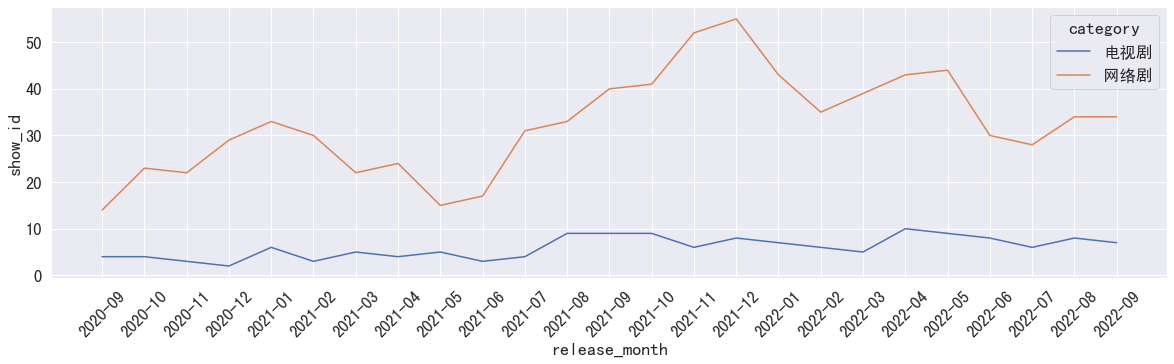

In [3]:
showdata['release_month']=pd.to_datetime(showdata['release_date'].tolist()).strftime('%Y-%m')
trend=showdata.groupby(['category','release_month']).count().reset_index()[['category','release_month','show_id']]
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(x="release_month", y="show_id",hue="category", data=trend)
plt.xticks(rotation=45) # 旋转45度
plt.show()

In [4]:
#处理导演和演员字段
import ast
def actors_list(x):
    x=ast.literal_eval(x)
    actors_list=[]
    for i in x:
        actors_list.append(i[0])
    return actors_list

def directors_list(x):
    return x.split("/")
showdata['director']=showdata['director'].apply(directors_list)
showdata['actor_info']=showdata['actor_info'].apply(actors_list)

In [5]:
def unfold(x):
    y=[]
    x=x.tolist()
    for i in x:
        for j in i:
            y.append(j)
    return y 

showdata_wlj=showdata[(showdata['category']=="网络剧")]
showdata_dsj=showdata[(showdata['category']=="电视剧")]
directors_wlj=set(unfold(showdata_wlj['director']))
directors_dsj=set(unfold(showdata_dsj['director']))
len(directors_dsj.intersection(directors_wlj))#交集有37位导演,既有电视剧又有网络剧

directors=unfold(showdata['director'])
directors_info=pd.DataFrame(pd.value_counts(directors)).reset_index()
directors_info.columns=['director','num']
#导演经历多于一部剧的
directors_last=set(directors_info[directors_info['num']>1]['director'].tolist())
len(directors_last) #211
len(directors_last.intersection(directors_wlj))#186/737
len(directors_last.intersection(directors_dsj))#62/200

actors=unfold(showdata['actor_info'])
actors_info=pd.DataFrame(pd.value_counts(actors)).reset_index()
actors_info.columns=['actor','num']
#演员经历多于一部剧的
actors_last=set(actors_info[actors_info['num']>1]['actor'].tolist())
len(actors_last)#2196

actors_wlj=set(unfold(showdata_wlj['actor_info']))
actors_dsj=set(unfold(showdata_dsj['actor_info']))
len(actors_wlj.intersection(actors_dsj))#968个演员同时出演电视剧和网络剧

968

In [6]:
#仅构建网络剧中的导演演员关系网络，按照导演、演员筛选出作品数大于1的导演演员进入关系节点
directors=showdata_wlj['director'].tolist()
actors=showdata_wlj['actor_info'].tolist()
relation=[]
for i in range(len(directors)):
    a_directors=directors[i]
    a_actors=actors[i]
    for j in a_directors:
        for k in a_actors:
            relation.append([j,k])
relationMap=pd.DataFrame(relation, columns=['director','actor'])
relationMap=relationMap[(relationMap['director'].isin(directors_last)) & (relationMap['actor'].isin(actors_last))]#3028
relationMap['count']=1

In [7]:
directors=list(set(relationMap['director'].tolist()))
actors=list(set(relationMap['actor'].tolist()))
director2node=dict(zip(directors,range(len(directors))))#0-179
actor2node=dict(zip(actors,range(len(directors),len(directors)+len(actors))))#180-1623
relationMap=relationMap.groupby(['director','actor']).count().reset_index()
#转化汉字人名为数字节点名
def director_node(x):
    return director2node[x]
def actor_node(x):
    return actor2node[x]
relationMap['director_node']=relationMap['director'].apply(director_node)
relationMap['actor_node']=relationMap['actor'].apply(actor_node)

relationMap.to_excel("relationMap.xlsx")

In [8]:
#输出节点字典
director_nodes = {'id':range(len(directors)),'label': directors}
director_nodes=pd.DataFrame.from_dict(director_nodes)
actor_nodes = {'id':range(len(directors),len(directors)+len(actors)), 'label': actors}
actor_nodes=pd.DataFrame.from_dict(actor_nodes)
#节点电视剧&网络剧两栖特征加工
director_amphibious=directors_dsj.intersection(directors_wlj)
actor_amphibious=actors_wlj.intersection(actors_dsj)
def directorAmphibious(x):
    if x in director_amphibious:
        return "director1"
    else:
        return "director0"
def actorAmphibious(x):
    if x in actor_amphibious:
        return "actor1"
    else:
        return "actor0"
director_nodes['type']=director_nodes['label'].apply(directorAmphibious)
actor_nodes['type']=actor_nodes['label'].apply(actorAmphibious)

#director_nodes.to_excel("director_nodes.xlsx")
#actor_nodes.to_excel("actor_nodes.xlsx")
nodes = pd.concat([director_nodes, actor_nodes], ignore_index=True)
#nodes.to_excel("nodes.xlsx")

In [9]:
import networkx as nx
G = nx.Graph() #创建一个空的图形
for i in range(len(nodes)):  
    G.add_node(nodes.iloc[i,0],label=nodes.iloc[i,1],type=nodes.iloc[i,2])  #添加节点，分类是为后面做区块分析用的
for i in range(len(relationMap)):  
    G.add_edge(relationMap.iloc[i,3], relationMap.iloc[i,4], weight=relationMap.iloc[i,2]) #添加边
nx.write_gexf(G,"director2actor.gexf")         

/Users/rebeccameow/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hot', ylabel='Density'>

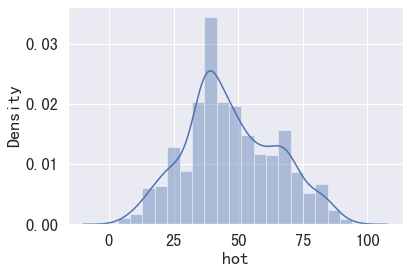

In [98]:
sns.distplot(showdata['hot'])

In [99]:
print("小圈子平均热度："+str(showdata[showdata['director'].apply(lambda x: (("文鸿毅" in x )or("王宏博"  in x ) or ("夏广炎" in x )))]['hot'].mean()))
print("整体平均热度："+ str(showdata['hot'].mean()))

小圈子平均热度：30.7296875
整体平均热度：47.08975026014574


In [10]:
relationMap['dtype']=relationMap['director'].apply(lambda x: director_nodes[director_nodes['label']==x]['type'].tolist()[0])
relationMap['atype']=relationMap['actor'].apply(lambda x: actor_nodes[actor_nodes['label']==x]['type'].tolist()[0])
relationMap

,director,actor,count,director_node,actor_node,dtype,atype
0,七娃,张宸逍,1,130,1520,director0,actor0
1,七娃,杨梓鑫,1,130,1588,director0,actor0
2,七娃,王嘉萌,1,130,970,director0,actor0
3,七娃,陈泇文,2,130,1605,director0,actor0
4,三石,冯馨辉,2,16,231,director0,actor0
...,...,...,...,...,...,...,...
2597,黎志,沈月,1,154,1349,director1,actor1
2598,黎志,章若楠,1,154,549,director1,actor1
2599,黎志,翟子路,1,154,503,director1,actor1
2600,黎志,薇薇,1,154,981,director1,actor1


In [101]:
len(relationMap[(relationMap['dtype']=='director1')&(relationMap['atype']=='actor0')])

234

In [11]:
pathlengths=[]
#单源最短路径算法求出节点v到图G每个节点的最短路径，存入pathlengths
for v in G.nodes():
    spl=nx.single_source_shortest_path_length(G,v)
    for p in spl.values():
        pathlengths.append(p)
#取出每条路径，计算平均值。
print("average shortest path length %s" % (sum(pathlengths)/len(pathlengths)))

average shortest path length 5.554896831493798


In [12]:
#算可以反映结构洞的约束系数
constraints_trial=nx.constraint(G)
degree_centrality=nx.degree_centrality(G)#点度中心度
betweenness_centrality=nx.betweenness_centrality(G,normalized=False)#中介中心度
closeness_centrality=nx.closeness_centrality(G, u=None, distance=None, wf_improved=False)#接近中心度

statistic_nodes = {'节点名':nodes['label'].tolist(),'节点性质':nodes['type'].tolist(),'约束系数': constraints_trial.values(),
'点度中心度': degree_centrality.values(),'中介中心度': betweenness_centrality.values(),'接近中心度': closeness_centrality.values()}
statistic_nodes=pd.DataFrame.from_dict(statistic_nodes)
statistic_nodes['degree']=(len(statistic_nodes)-1)*statistic_nodes['点度中心度']

statistic_nodes.to_excel("statistic_nodes.xlsx")

In [25]:
#点度中心度标准化
director_central=statistic_nodes.iloc[181:,:]
actor_central=statistic_nodes.iloc[:181,:]
director_central['点度中心度']=director_central['点度中心度'].apply(lambda x: x*1624/1443)
actor_central['点度中心度']=actor_central['点度中心度'].apply(lambda x: x*1624/181)
statistic_nodes=pd.concat([director_central,actor_central], ignore_index=True)

/var/folders/nv/510r248567jfm29jkw7r7b240000gn/T/ipykernel_42194/3700545622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  director_central['点度中心度']=director_central['点度中心度'].apply(lambda x: x*1624/1443)
/var/folders/nv/510r248567jfm29jkw7r7b240000gn/T/ipykernel_42194/3700545622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actor_central['点度中心度']=actor_central['点度中心度'].apply(lambda x: x*1624/181)


In [27]:
statistic_nodes['节点分类']=statistic_nodes['节点性质'].apply(lambda x:x[:-1])
statistic_nodes.sort_values(by=['节点分类','degree'],ascending=False).groupby('节点分类').head(10)

,节点名,节点性质,约束系数,点度中心度,中介中心度,接近中心度,degree,节点分类
1530,郭虎,director0,0.016393,0.337224,82141.647594,0.248436,61.0,director
1587,天毅,director1,0.016949,0.326168,77477.878393,0.218940,59.0,director
1511,白云默,director0,0.017857,0.309583,78068.028379,0.247959,56.0,director
1558,任海涛,director0,0.018868,0.292998,76192.316167,0.250688,53.0,director
1559,于中中,director0,0.018868,0.292998,130733.028919,0.265013,53.0,director
1577,王晓明,director1,0.018868,0.292998,52833.478396,0.239376,53.0,director
1617,温德光,director1,0.020833,0.265357,128461.915865,0.260205,48.0,director
1454,陈畅,director0,0.023810,0.232187,63714.177587,0.226164,42.0,director
1615,吴强,director0,0.025641,0.215602,56531.728502,0.246147,39.0,director
1483,于永刚,director0,0.026316,0.210074,77089.408907,0.249798,38.0,director


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

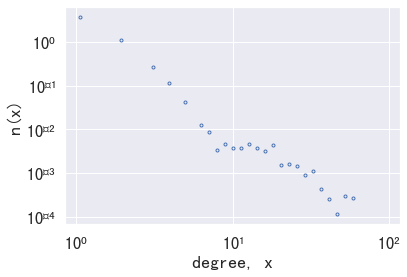

In [105]:
bins = np.logspace(0.0, 2.0, num=40)
Y, X = np.histogram(statistic_nodes['degree'], bins=bins, density=True)

X = [x*np.sqrt(bins[1]) for x in X][:-1] 

#plt.ylim((0.00001, 4))
plt.xlabel('degree, x')
plt.ylabel("n(x)")
plt.loglog(X,Y, 'o', markersize=3, markerfacecolor='none')
plt.show()

/Users/rebeccameow/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='degree', ylabel='Density'>

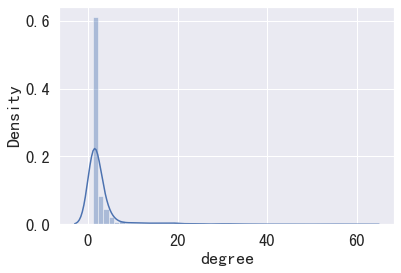

In [106]:
sns.distplot(statistic_nodes['degree'])

/Users/rebeccameow/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='节点性质', ylabel='count'>

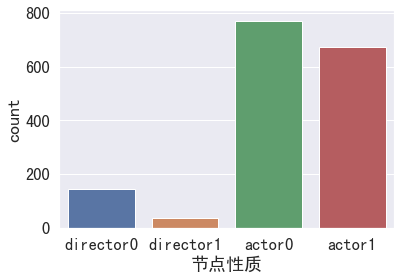

In [107]:
sns.countplot(statistic_nodes['节点性质'])

In [28]:
statistic_nodes.groupby('节点性质').mean().reset_index()

,节点性质,约束系数,点度中心度,中介中心度,接近中心度,degree
0,actor0,0.705402,0.001280,1745.446190,0.206045,1.845655
1,actor1,0.746822,0.001217,1362.168136,0.188081,1.754464
2,director0,0.206532,0.073633,16655.260230,0.291076,13.319444
3,director1,0.090094,0.102198,21998.933157,0.207476,18.486486


In [45]:
director0_compare=statistic_nodes[statistic_nodes['节点性质']=='director0']
director1_compare=statistic_nodes[statistic_nodes['节点性质']=='director1']
actor0_compare=statistic_nodes[statistic_nodes['节点性质']=='actor0']
actor1_compare=statistic_nodes[statistic_nodes['节点性质']=='actor1']

In [ ]:
#独立样本T检验
'''
比较两个样本所代表的两个总体均值是否存在显著差异。除了要求样本来自正态分布，还要求两个样本的总体方差相等“方差齐性”。
'''
from scipy.stats import ttest_ind,norm,f
def ftest(s1,s2):
	'''F检验样本总体方差是否相等'''
	print("Null Hypothesis:var(s1)=var(s2)，α=0.05")
	F = np.var(s1)/np.var(s2)
	v1 = len(s1) - 1
	v2 = len(s2) - 1
	p_val = 1 - 2*abs(0.5-f.cdf(F,v1,v2))
	print(p_val)
	if p_val < 0.05:
		print("Reject the Null Hypothesis.")
		equal_var=False
	else:
		print("Accept the Null Hypothesis.")
		equal_var=True
	return equal_var
	 	
def ttest_ind_fun(s1,s2):
	'''t检验独立样本所代表的两个总体均值是否存在差异'''
	equal_var = ftest(s1,s2)
	print("Null Hypothesis:mean(s1)=mean(s2)，α=0.05")
	ttest,pval = ttest_ind(s1,s2,equal_var=equal_var)
	if pval < 0.05:
		print("Reject the Null Hypothesis.")
	else:
		print("Accept the Null Hypothesis.")
	return pval

In [50]:
ttest_ind_fun(actor0_compare['约束系数'],actor1_compare['约束系数'])#reject
ttest_ind_fun(actor0_compare['接近中心度'],actor1_compare['接近中心度'])#reject
ttest_ind_fun(actor0_compare['中介中心度'],actor1_compare['中介中心度'])#reject
ttest_ind_fun(actor0_compare['点度中心度'],actor1_compare['点度中心度'])#accept
ttest_ind_fun(director0_compare['约束系数'],director1_compare['约束系数'])#reject
ttest_ind_fun(director0_compare['接近中心度'],director1_compare['接近中心度'])#reject
ttest_ind_fun(director0_compare['中介中心度'],director1_compare['中介中心度'])#accept
ttest_ind_fun(director0_compare['点度中心度'],director1_compare['点度中心度'])#reject

Null Hypothesis:var(s1)=var(s2)，α=0.05
0.9969361279507631
Accept the Null Hypothesis.
Null Hypothesis:mean(s1)=mean(s2)，α=0.05
Reject the Null Hypothesis.
Null Hypothesis:var(s1)=var(s2)，α=0.05
2.220446049250313e-16
Reject the Null Hypothesis.
Null Hypothesis:mean(s1)=mean(s2)，α=0.05
Reject the Null Hypothesis.
Null Hypothesis:var(s1)=var(s2)，α=0.05
0.004995702421537462
Reject the Null Hypothesis.
Null Hypothesis:mean(s1)=mean(s2)，α=0.05
Reject the Null Hypothesis.
Null Hypothesis:var(s1)=var(s2)，α=0.05
0.8915252835247073
Accept the Null Hypothesis.
Null Hypothesis:mean(s1)=mean(s2)，α=0.05
Accept the Null Hypothesis.
Null Hypothesis:var(s1)=var(s2)，α=0.05
1.76815406760511e-09
Reject the Null Hypothesis.
Null Hypothesis:mean(s1)=mean(s2)，α=0.05
Reject the Null Hypothesis.
Null Hypothesis:var(s1)=var(s2)，α=0.05
2.220446049250313e-16
Reject the Null Hypothesis.
Null Hypothesis:mean(s1)=mean(s2)，α=0.05
Reject the Null Hypothesis.
Null Hypothesis:var(s1)=var(s2)，α=0.05
0.18366114122333055
A

0.02392249312988439

In [109]:
#关系权重
relationMap[relationMap['count']>1]#315

,director,actor,count,director_node,actor_node,dtype,atype
3,七娃,陈泇文,2,124,507,director0,actor0
4,三石,冯馨辉,2,104,1303,director0,actor0
5,三石,蔡沐锦,2,104,655,director0,actor0
6,三石,钟熙凯,2,104,324,director0,actor0
7,严艺文,吴以涵,2,180,1469,director0,actor0
...,...,...,...,...,...,...,...
2543,麦田,紫红,2,88,858,director0,actor0
2546,麦田,覃沁璇,3,88,1136,director0,actor0
2547,麦田,郑拓疆,2,88,847,director0,actor0
2550,黄伟,国歌,2,163,1154,director0,actor1


/Users/rebeccameow/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


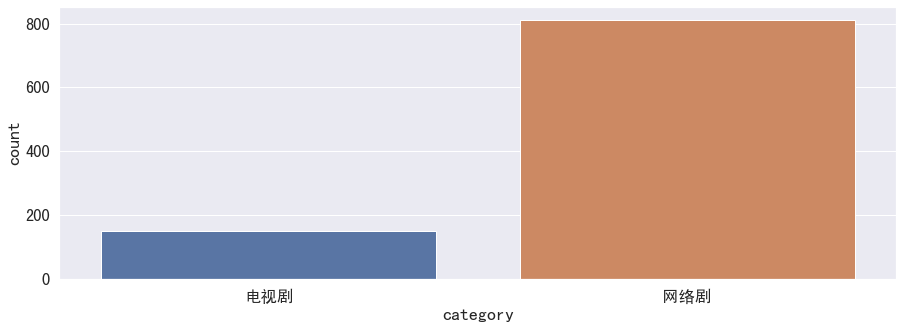

In [110]:
plt.figure(figsize=(15,5))
sns.countplot(showdata['category'])
plt.show()

In [111]:
#回归准备，缺失值填充
mean_val = showdata['episode'].mean()
showdata['episode'].fillna(mean_val, inplace=True)
showdata['episode'].isnull().sum()
#处理平台
showdata=pd.get_dummies(showdata,columns=['platform_names'])
#处理古装
def guzhuang(x):
    x=str(x)
    if "古" in x:
        return 1
    else:
        return 0
showdata['guzhuang']=showdata['type'].apply(guzhuang)
#处理time
month_list=['2020-09','2020-10','2020-11','2020-12','2021-01','2021-02','2021-03','2021-04','2021-05','2021-06','2021-07','2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04','2022-05','2022-06','2022-07','2022-08','2022-09']
month_dict=dict(zip(month_list,range(len(month_list))))
showdata['time']=showdata['release_month'].apply(lambda x: month_dict[x])

In [112]:
statistic_director=statistic_nodes[statistic_nodes['节点分类']=='director'][['节点名','degree','约束系数']]
statistic_actor=statistic_nodes[statistic_nodes['节点分类']=='actor'][['节点名','degree','约束系数']]
statistic_director['degree']=statistic_director['degree'].apply(lambda x:x/len(statistic_actor))
statistic_actor['degree']=statistic_actor['degree'].apply(lambda x:x/len(statistic_director))

In [113]:
def actor_con(x):
    return statistic_actor[statistic_actor['节点名'].isin(x)]['约束系数'].min()
def actor_degree(x):
    return statistic_actor[statistic_actor['节点名'].isin(x)]['degree'].max()
def director_con(x):
    return statistic_director[statistic_director['节点名'].isin(x)]['约束系数'].min()
def director_degree(x):
    return statistic_director[statistic_director['节点名'].isin(x)]['degree'].max()
showdata['actor_con']=showdata['actor_info'].apply(actor_con)
showdata['actor_degree']=showdata['actor_info'].apply(actor_degree)
showdata['director_con']=showdata['director'].apply(director_con)
showdata['director_degree']=showdata['director'].apply(director_degree)

showdata.dropna(subset=['director_con', 'director_degree'],
          axis=0, # axis=0表示删除行；
          how='any', # 两列中任意一个出现空值，就删掉该行
          inplace=True # inplace=True表示在原df上进行修改；
          )

In [114]:
showdata=showdata[['hot','episode','guzhuang', 'platform_names_B站', 'platform_names_乐视视频',
       'platform_names_优酷', 'platform_names_多平台', 'platform_names_搜狐视频',
       'platform_names_爱奇艺', 'platform_names_腾讯视频', 'platform_names_芒果TV',
       'time', 'actor_con', 'actor_degree', 'director_con', 'director_degree']]
showdata.columns=['hot','episode','guzhuang', 'Bilibili', 'LeTV',
       'Youku', 'multi', 'Sohu',
       'Aiqy', 'Tencent', 'MangoTV',
       'time', 'actor_con', 'actor_degree', 'director_con', 'director_degree']

In [116]:
showdata.dropna(how='any', inplace=True)
showdata.to_csv('regression.csv')